x0,fx0: [[  0.        ]
 [ 11.45074413]
 [  0.        ]
 [  0.        ]
 [-14.23945722]
 [  0.        ]
 [  0.        ]
 [  0.        ]] 7264.199503727192
A: [[ 2.         -0.11705112  0.06933272 -0.09939571 -0.19796162  0.12985488
   0.01349761 -0.03215592]
 [-0.11705112  2.          0.07306473 -0.02821169  0.18304428  0.02883831
  -0.09583379 -0.12072797]
 [ 0.06933272  0.07306473  2.          0.0970781  -0.05332915 -0.12819375
  -0.05297713 -0.21141942]
 [-0.09939571 -0.02821169  0.0970781   2.         -0.05141508  0.07134636
  -0.24686912  0.09585019]
 [-0.19796162  0.18304428 -0.05332915 -0.05141508  2.          0.17515946
   0.07495507  0.21623856]
 [ 0.12985488  0.02883831 -0.12819375  0.07134636  0.17515946  2.
  -0.10086022  0.01221077]
 [ 0.01349761 -0.09583379 -0.05297713 -0.24686912  0.07495507 -0.10086022
   2.         -0.17915752]
 [-0.03215592 -0.12072797 -0.21141942  0.09585019  0.21623856  0.01221077
  -0.17915752  2.        ]]
b: [[  2.01949609]
 [-20.29503703]
 [  7.

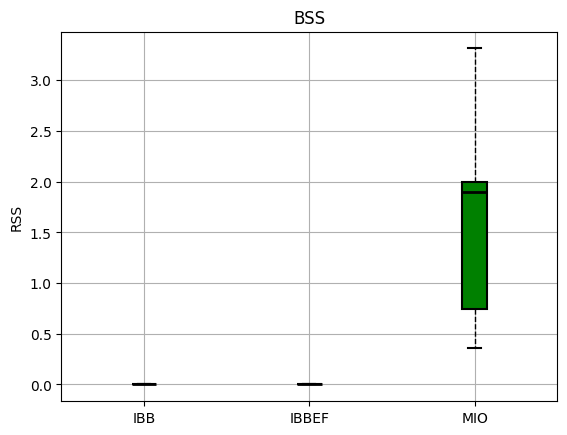

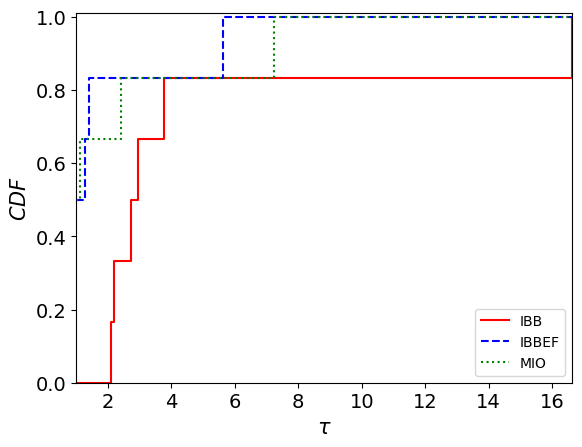

In [ ]:

import numpy as np
from scipy import linalg
import pandas as pd
import pickle

import testalg
import matplotlib.pyplot as plt
import utility.perprof as perprof 
import utility.boxplot as boxplot
import utility.relgap as relgap

num_dim=3   # no. of examples of different dimensions
dim_egs=np.array([8,10,12])  # dimension of examples
num_data_pts=np.array([200,200,200])
num_k_values=2    
k_values=np.array([2,4]) 
s0_values=5*np.ones(num_dim,dtype=int) # no. of nonzero values in b0
num_instances=1           # no. of instances to run for each example
alg_flag=np.array([1, 1, 1]) # =1 include in testing, =0 do not include  
num_alg=3
b0_type=3   # to generate the true coefficient vector b0

# initialize the arrays to save the final output
rss = np.zeros( (num_dim*num_k_values,num_alg) )
cpu_time = np.zeros( (num_dim*num_k_values,num_alg) )
num_iter = np.zeros( (num_dim*num_k_values,num_alg) )
stop_flag = -1*np.zeros( (num_dim*num_k_values,num_alg) )
output_excel = np.nan*np.ones( (6+np.max(dim_egs),num_dim*num_k_values*num_alg) )
ctr = 0 # used for saving data in output_excel
for i in range(num_dim):

    p=dim_egs[i]
    n=num_data_pts[i]
    mu=np.zeros(p)
    sigma=np.eye(p)
    snr=0.5
    s0=s0_values[i]
    if b0_type==1: # example 1
        b0=np.zeros(p)
        i0=np.ceil(np.linspace(0,p,num=s0,endpoint=False)).astype(int) # get s0 evenly spaced indices, round the next integer if needed
        b0[i0]=1 
    elif b0_type==2: # example 2
        b0=np.zeros(p)
        b0[0:s0]=1 # make first s0 entries 1
    elif b0_type==3: # example 3
        b0=np.zeros(p)   
        i0 = np.random.randint(0,p,s0).astype(int) # pick s0 random indices to make nonzero
        j0 = np.random.randint(1,5,s0) # pick s0 random integers b/w 1 and 5
        b0[i0]=j0

    b0 = np.reshape(b0, (-1,1)) # make it a col array
    
    # run the algorithms and save the output
    for j in range(num_k_values): # for each k value, run the alg
        
        k = k_values[j]
        stop_flag_each_alg, cpu_time_each_alg, rss_each_alg, sol_each_alg=testalg.main(p,n,k,b0,snr,mu,sigma,num_instances,num_alg,alg_flag)
        rss[j+i*num_k_values,:]=rss_each_alg 
        cpu_time[j+i*num_k_values,:]=cpu_time_each_alg
        stop_flag[j+i*num_k_values,:]=stop_flag_each_alg
        print(rss_each_alg[0],cpu_time_each_alg[0],stop_flag_each_alg[0],sol_each_alg[0])
        
        output_excel[0:6+p,ctr] = np.hstack(([p, n, k, rss_each_alg[0], cpu_time_each_alg[0],stop_flag_each_alg[0]],sol_each_alg[0] ))
        output_excel[0:6+p,ctr+1] = np.hstack(([p, n, k, rss_each_alg[1], cpu_time_each_alg[1],stop_flag_each_alg[1]],sol_each_alg[1] ))
        output_excel[0:6+p,ctr+2] = np.hstack(([p, n, k, rss_each_alg[2], cpu_time_each_alg[2],stop_flag_each_alg[2]],sol_each_alg[2] )) 
        ctr += 3
    


# save the output in .pkl file
print('rss:',rss)
print('cpu:',cpu_time)
print('stop_flag:',stop_flag)

# prepare output to be saved in excel file using pandas dataframe
column_names = num_dim*num_k_values*['IBB','IBBEF','MIO']
row_names = ['p','n','k','rss','cputime','stopflag']
for i in range(np.max(dim_egs[0:num_dim])):
    row_names.append(f"x{i+1}")

dataframe = pd.DataFrame(output_excel, columns=column_names, index=row_names)
dataframe.to_excel('data.xlsx', index=True, header=True)
print(dataframe)

# save the output in .pkl file
output_pkl={'rss':rss,'cpu':cpu_time,'stop_flag':stop_flag}
filename = 'data.pkl'

try:
    with open(filename, 'wb') as file:
        pickle.dump(output_pkl, file)
    print(f"Data saved successfully to {filename}")
except Exception as e:
    print(f"An error occurred while saving data: {e}")

""" 
try:
    with open(filename, 'rb') as file:
        loaded_data = pickle.load(file)
    print(f"Data loaded successfully from {filename}: {loaded_data}")
except FileNotFoundError:
    print(f"Error: File '{filename}' not found.")
except Exception as e:
    print(f"An error occurred while loading data: {e}")    
"""    

# create box plots
boxplot.main(relgap.main(rss))

# create a performance profile of CPU time data
perprof.main(cpu_time,linespecs=['r-', 'b--','g:'],legendnames=['IBB','IBBEF', 'MIO'])
       